Performance test

In [ ]:
import torch
from tqdm.auto import tqdm

device = "cuda"
n = 10000
W = 0.5 * torch.randn(n, n, device=device) / n**0.5
x = torch.randn(n, device=device)
phi = torch.tanh
dt = 1e-3
for i in (pbar := tqdm(range(10000))):
    x += (-x + phi(W @ x)) * dt
    if i % 1000 == 0:
        pbar.set_description(f"{x.mean():.2f}, {x.std():.2f}")

Empirical DNNs

In [62]:
# del W
torch.cuda.empty_cache()

Bottleneck is generating Levy samples from scipy. Use [torchlevy](https://github.com/KU-LIM-Lab/torchlevy) instead, which translates the same algorithm to torch primitives.

The speedup is massive (60x) but it has occasional issues with generating nans. The speedup holds even against a pure numpy implementation (45x). Using torchlevy on cpu is faster than a pure numpy implementation by about 3x.

In [ ]:
# !pip install git+https://github.com/UNIST-LIM-Lab/torchlevy.git

/import/silo3/wardak/.venv/lib64/python3.9/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


  0%|          | 0/10 [00:00<?, ?it/s]

/import/silo3/wardak/.venv/lib64/python3.9/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/import/silo3/wardak/.venv/lib64/python3.9/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/import/silo3/wardak/.venv/lib64/python3.9/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tenso

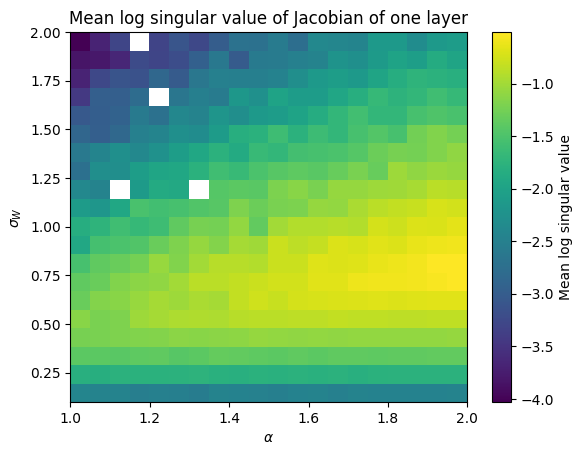

In [1]:
import RMT

from tqdm.auto import tqdm
import torch

from functools import partial
import multiprocessing as mp

mp.set_start_method("spawn", force=True)

alphas = torch.linspace(1, 2, 20)
sigmas_W = torch.linspace(0.1, 2, 20)

with mp.Pool(4) as pool:
    results = list(
        tqdm(
            pool.imap(
                partial(
                    RMT.worker,
                    alphas=alphas,
                    sigma_b=0,
                    phi=torch.tanh,
                    width=1000,
                    depth=50,
                ),
                sigmas_W,
            ),
            total=10,
        )
    )
import matplotlib.pyplot as plt

plt.imshow(results, aspect="auto", extent=(1, 2, 0.1, 2), origin="lower")
plt.colorbar(label="Mean log singular value")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sigma_W$")
plt.title("Mean log singular value of Jacobian of one layer")
plt.show()